In [2]:
from typing import Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import path_imports
from sklearn.feature_extraction.text import (
    CountVectorizer,
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import (
    train_test_split,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_sample_weight
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop

from src.classification.my_naive_bayes import (
    CountVectorizer,
    MultinomialNB,
    MyNaiveBayes,
    en_stop,
)
from src.read_corpus import read_corpus

## Create dataset

### Read corpus

In [3]:
df_all = read_corpus()
df_all

100%|██████████| 29/29 [00:03<00:00,  7.81it/s]


,category,name,date,text
0,speech,Donald Trump,2019,Thank you everybody. Thank you and Vice Presi...
1,speech,Donald Trump,2019,"ell, thank you very much. And hello, Tupelo. T..."
2,speech,Donald Trump,2019,Thank you very much everybody. Thank you. Wow...
3,speech,Donald Trump,2020,"Thank you, thank you. Wow. Wow, and I'm thrill..."
4,speech,Donald Trump,2020,"Wow, that's a big crowd. This is a big crowd. ..."
...,...,...,...,...
107,state-the-union-written-messages,Harry S Truman,"December 20, 1948",\nCITATION ACCOMPANYING THE AWARD OF\nTHE MEDA...
108,state-the-union-written-messages,Harry S Truman,"June 01, 1945",\nCITATION FOR THE LEGION OF MERIT\nDEGREE OF ...
109,state-the-union-written-messages,Dwight D. Eisenhower,"August 04, 1955","\n[Text read by Cmdr. Edward L. Beach, Naval A..."
110,state-the-union-written-messages,Harry S Truman,"September 10, 1945",\nCITATION FOR THE MEDAL OF HONOR\nGENERAL JON...


### Filter by categories and by president

In [4]:
# categories = ["debate", "speech", "tweet"]
categories = ["tweet"]
presidents = ["Barack Obama", "Donald Trump", "Joe Biden"]

df = df_all.copy()
df = df[df["category"].isin(categories)]
df = df[df["name"].isin(presidents)]
df["category"].unique().tolist(), df["name"].unique().tolist()

(['tweet'], ['Donald Trump', 'Barack Obama', 'Joe Biden'])

### Split into train and test

In [5]:
X = df["text"]
y = df["name"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
print(
    "sample weights unique coefs :",
    pd.DataFrame(sample_weights, columns=["name"]).name.unique(),
)

sample weights unique coefs : [0.42540184 2.89457703 3.29155445]


## Create model

In [6]:
model = MyNaiveBayes(
    cv=CountVectorizer(tokenizer=None, ngram_range=(1, 1), stop_words=list(en_stop)),
    clf=MultinomialNB(),
)

## Train

In [7]:
model.fit(X_train, y_train, multinomialnb__sample_weight=sample_weights)
print(f"Features dimension: {len(X_train), len(model.cv.vocabulary_)}")
model.model.steps

/home/secouss/repos/nlp-usa-presidents/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


Features dimension: (47665, 54950)


[('countvectorizer',
  CountVectorizer(stop_words=['’ve', 'since', 'yet', '‘s', 'your', 'next', 'him',
                              'against', 'will', 'seeming', 'ever', 'could', 're',
                              'whereafter', 'there', 'formerly', 'the', 'hereby',
                              'well', 'without', 'back', 'upon', 'until', 'whom',
                              'themselves', 'latterly', 'her', 'by', 'might',
                              'neither', ...])),
 ('multinomialnb', MultinomialNB())]

## Evaluate

### Predict

In [8]:
y_pred = model.predict(X_test)

### Table (precision, recall, f1-score)

In [9]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

Barack Obama       0.92      0.94      0.93      1362
Donald Trump       0.99      0.89      0.94      9345
   Joe Biden       0.53      0.94      0.68      1210

    accuracy                           0.90     11917
   macro avg       0.81      0.92      0.85     11917
weighted avg       0.94      0.90      0.91     11917



### Confusion Matrix

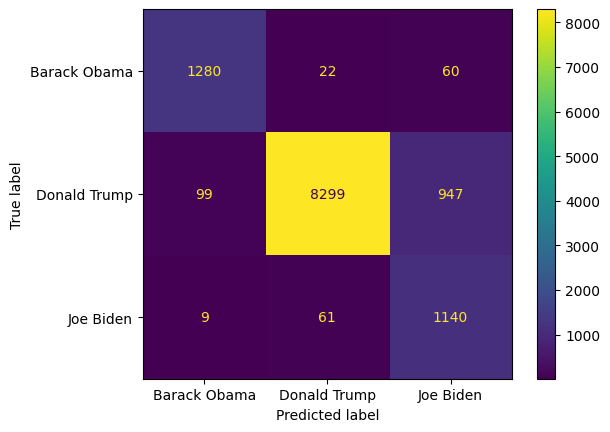

In [10]:
cm = confusion_matrix(y_test, y_pred, labels=model.clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.clf.classes_)
disp.plot()
plt.show()

## Explicabilities

### Which words are the most used for each president 

In [11]:
res = model.get_most_important_token(n=15)
for president, word in res.items():
    print(f"{president} : {word}")

Barack Obama : ['ofa', 'bo', 'http', 'president', 'obama', 'com', 'twitter', 'pic', 'health', 'congress', 'time', 'americans', 'today', 'care', 'watch']
Donald Trump : ['co', 'https', 'realdonaldtrump', 'great', 'trump', 'amp', 'http', 'thank', 'president', 'people', 'country', 'thanks', 'new', 'america', 'big']
Joe Biden : ['co', 'https', 'president', 'trump', 'donald', 'need', 'today', 'biden', 'country', 'http', 'nation', 'america', 'll', 'day', 'american']


### Which text fails ? What does they contain ?

In [12]:
dfr = pd.DataFrame({"text": list(X_test), "true": list(y_test), "pred": y_pred})

true_label = "Joe Biden"
predicted_label = "Barack Obama"

dft = dfr.copy()
dft = dft[dft["true"] == true_label]
dft = dft[dft["pred"] == predicted_label]
dft.text.head(n=10).to_list()

['Every CEO in America should be focusing on workers, families, and communities — not executive compensation and share prices.',
 "It's not enough to just thank our essential workers — we need to pay them. As president, I’ll:\n\n- Raise the minimum wage to $15\n- End the tipped minimum wage\n- End the sub-minimum wage for people with disabilities\n- Ensure everyone has strong benefits",
 'President @BarackObama turns 51 tomorrow—join the First Lady and sign his birthday card: http://t.co/U1VQRjdu',
 'From 18 tax cuts to more access to loans, find out how President Obama is giving small businesses a leg up: http://t.co/4DtjRmNL',
 'There are actions that Congress can take right now if they were to listen to the majority of the American people who want to see our government take action to stop gun violence.',
 '“He has done more for Israel’s security than any President since Harry Truman.”—VP Biden on President Obama',
 'President Obama: "We are on pace to double our exports. That\'s cre

### Given a text, which words have influenced the most for predicting the president

#### Take one

In [13]:
sample = dft.iloc[7]
text = sample["text"]
name = sample["true"]
name, text

('Joe Biden',
 'A #FF this week for @ObamaInaugural—everything you need to know for President Obama and VP Biden’s inauguration on January 21, 2013.')

#### See the prediction

In [14]:
model.predict([text])[0]

'Barack Obama'

#### Show the words that have influenced the most the prediction

In [15]:
model.most_important_words(text)

{'Barack Obama': array(['president', 'obama'], dtype=object),
 'Donald Trump': array(['president', 'obama', 'need', 'know', 'biden'], dtype=object),
 'Joe Biden': array(['president', 'need', 'biden', 'vp', 'know'], dtype=object)}